Epoch [1/20], Loss: 0.3005
Epoch [2/20], Loss: 0.2017
Epoch [3/20], Loss: 0.2011
Epoch [4/20], Loss: 0.2012
Epoch [5/20], Loss: 0.2016
Epoch [6/20], Loss: 0.2013
Epoch [7/20], Loss: 0.2016
Epoch [8/20], Loss: 0.2015
Epoch [9/20], Loss: 0.2013
Epoch [10/20], Loss: 0.2017
Epoch [11/20], Loss: 0.2012
Epoch [12/20], Loss: 0.2011
Epoch [13/20], Loss: 0.2011
Epoch [14/20], Loss: 0.2013
Epoch [15/20], Loss: 0.2007
Epoch [16/20], Loss: 0.2005
Epoch [17/20], Loss: 0.2012
Epoch [18/20], Loss: 0.2010
Epoch [19/20], Loss: 0.2011
Epoch [20/20], Loss: 0.2009
Training Complete!


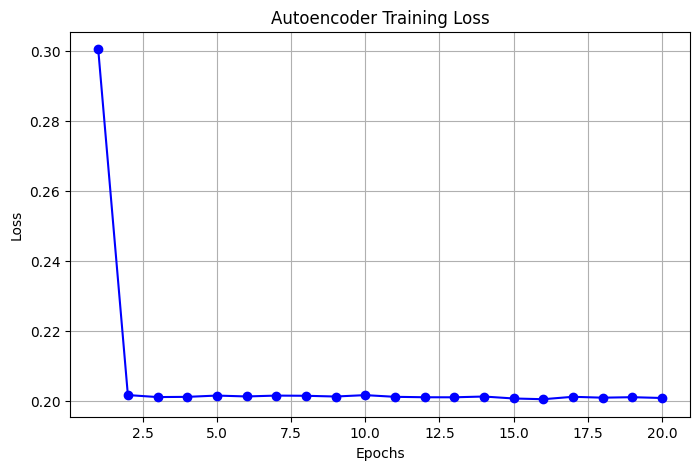

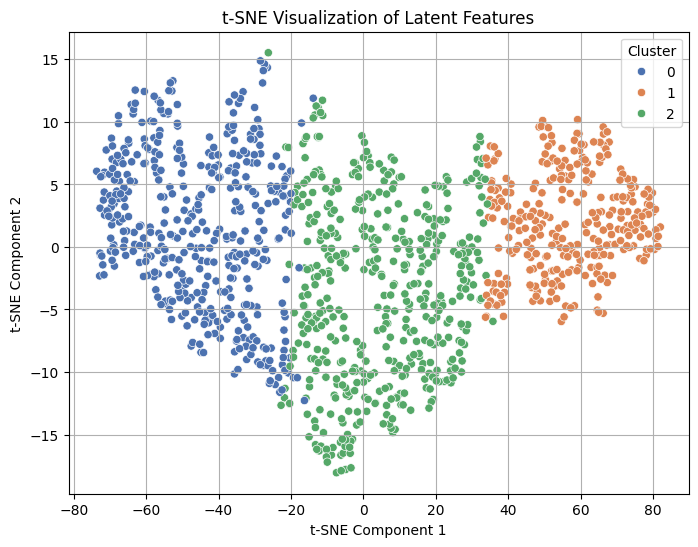

/tmp/ipykernel_4033030/3306580902.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cluster_labels, palette="viridis")


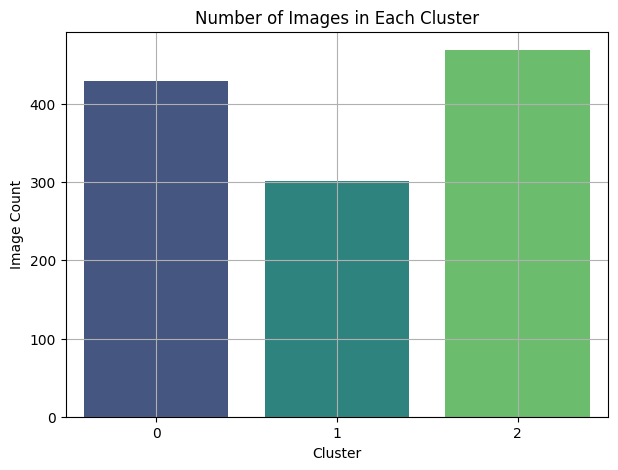

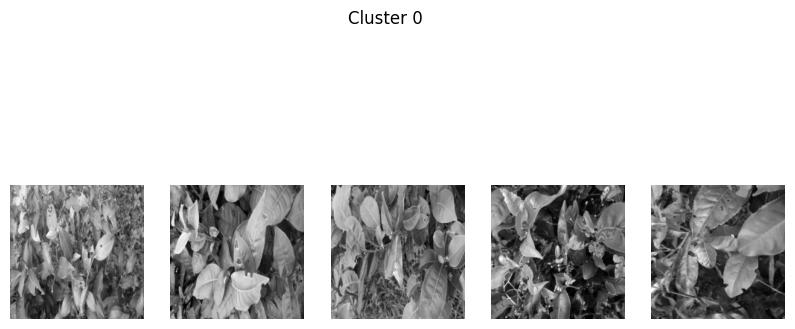

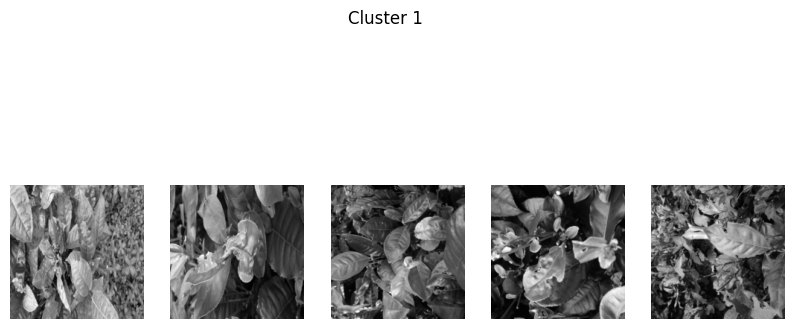

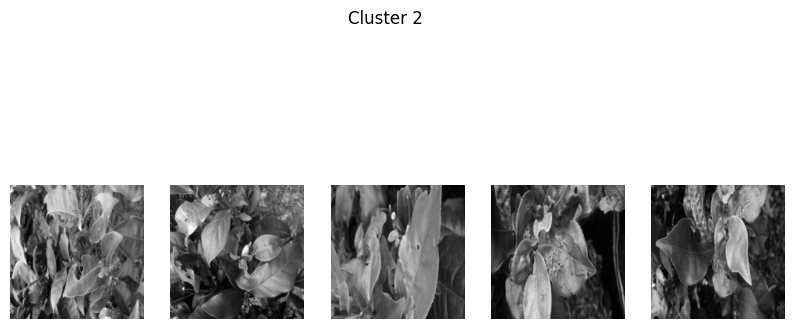

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import os

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset path
dataset_path = "/home/idrone2/Desktop/sana"  # Change this to your dataset path

# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((180, 180)),  # Resize images
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Load dataset from three folders
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(180 * 180, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)  # Latent space
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 180 * 180),
            nn.Sigmoid(),  # Output scaled between 0-1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder
latent_dim = 32  # Compressed feature size
autoencoder = Autoencoder(latent_dim).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train Autoencoder
epochs = 20
train_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for images, _ in dataloader:
        images = images.to(device).view(images.size(0), -1)  # Flatten images

        # Forward pass
        reconstructed = autoencoder(images)
        loss = criterion(reconstructed, images)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

print("Training Complete!")

# Plot Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.grid()
plt.show()

# Extract features from the encoder
encoded_features = []
labels_list = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device).view(images.size(0), -1)
        features = autoencoder.encoder(images)
        encoded_features.append(features.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

# Convert to NumPy array
encoded_features = np.vstack(encoded_features)

# Apply K-Means clustering
num_clusters = 3  # Since you have 3 folders (3 classes)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_features)

# Visualize t-SNE of Latent Representations
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(encoded_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=cluster_labels, palette="deep")
plt.title("t-SNE Visualization of Latent Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# Plot Cluster Size Distribution
plt.figure(figsize=(7, 5))
sns.countplot(x=cluster_labels, palette="viridis")
plt.title("Number of Images in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Image Count")
plt.xticks(range(num_clusters))
plt.grid()
plt.show()

# Display sample images from each cluster
def plot_cluster_images(cluster_label, num_samples=5):
    plt.figure(figsize=(10, 5))
    count = 0
    for i, (image_path, label) in enumerate(zip(dataset.imgs, cluster_labels)):
        if label == cluster_label and count < num_samples:
            image = dataset[i][0].squeeze().numpy()
            plt.subplot(1, num_samples, count + 1)
            plt.imshow(image, cmap="gray")
            plt.axis("off")
            count += 1
    plt.suptitle(f"Cluster {cluster_label}")
    plt.show()

# Show images from each cluster
for cluster in range(num_clusters):
    plot_cluster_images(cluster)


Epoch [1/20], Loss: 0.2808
Epoch [2/20], Loss: 0.1813
Epoch [3/20], Loss: 0.1814
Epoch [4/20], Loss: 0.1813
Epoch [5/20], Loss: 0.1813
Epoch [6/20], Loss: 0.1812
Epoch [7/20], Loss: 0.1813
Epoch [8/20], Loss: 0.1813
Epoch [9/20], Loss: 0.1809
Epoch [10/20], Loss: 0.1812
Epoch [11/20], Loss: 0.1809
Epoch [12/20], Loss: 0.1808
Epoch [13/20], Loss: 0.1811
Epoch [14/20], Loss: 0.1808
Epoch [15/20], Loss: 0.1810
Epoch [16/20], Loss: 0.1802
Epoch [17/20], Loss: 0.1802
Epoch [18/20], Loss: 0.1807
Epoch [19/20], Loss: 0.1801
Epoch [20/20], Loss: 0.1798
Training Complete!


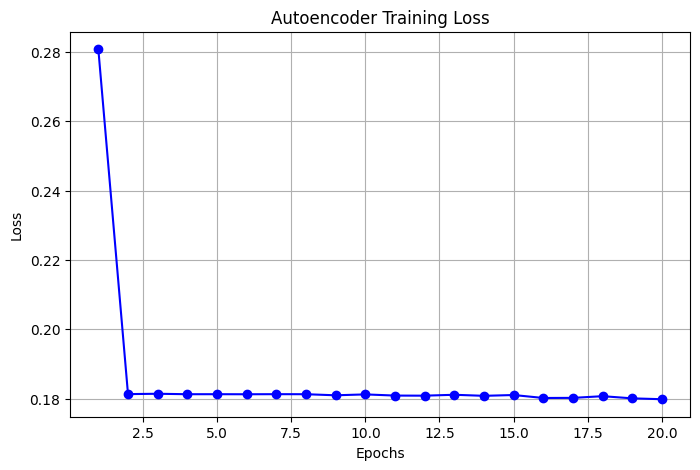

Silhouette Score: 0.4525


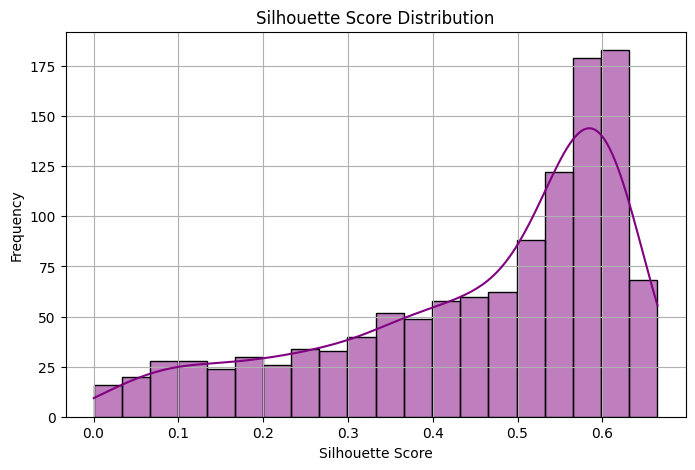

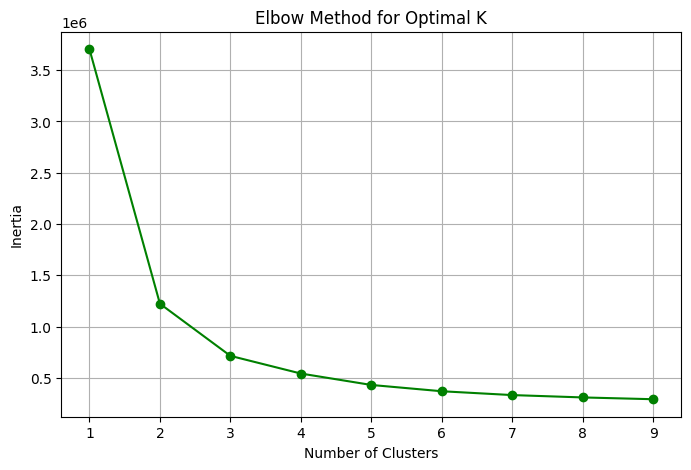

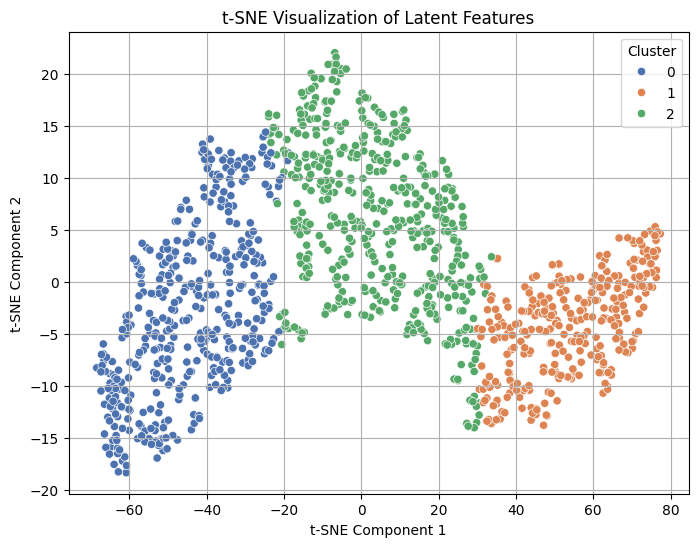

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

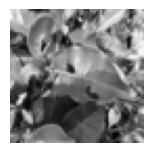

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
import seaborn as sns
import umap

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset path
dataset_path = "/home/idrone2/Desktop/sana"  # Change this to your dataset path

# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 64),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
latent_dim = 32
autoencoder = Autoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train Autoencoder
epochs = 20
train_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for images, _ in dataloader:
        images = images.to(device).view(images.size(0), -1)
        reconstructed = autoencoder(images)
        loss = criterion(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

print("Training Complete!")

# 1. 📈 Plot Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.grid()
plt.show()

# 2. Extract Features for Clustering
encoded_features = []
original_images = []
with torch.no_grad():
    for images, _ in dataloader:
        images = images.to(device).view(images.size(0), -1)
        features = autoencoder.encoder(images)
        encoded_features.append(features.cpu().numpy())
        original_images.append(images.cpu().numpy())

encoded_features = np.vstack(encoded_features)
original_images = np.vstack(original_images)

# 3. Apply K-Means Clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_features)

# 4. 🏆 Evaluate Clustering Quality (Silhouette Score)
silhouette_avg = silhouette_score(encoded_features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# 5. 📉 Plot Silhouette Score Distribution
silhouette_values = silhouette_samples(encoded_features, cluster_labels)
plt.figure(figsize=(8, 5))
sns.histplot(silhouette_values, bins=20, kde=True, color='purple')
plt.title("Silhouette Score Distribution")
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# 6. 📊 Plot K-Means Inertia (Elbow Method)
inertia_values = []
for k in range(1, 10):
    kmeans_test = KMeans(n_clusters=k, random_state=42).fit(encoded_features)
    inertia_values.append(kmeans_test.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia_values, marker='o', linestyle='-', color='green')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid()
plt.show()

# 7. 📍 Plot t-SNE of Latent Features
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(encoded_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=cluster_labels, palette="deep")
plt.title("t-SNE Visualization of Latent Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# 8. 🔍 Reconstruction Quality Comparison
n_samples = 5
plt.figure(figsize=(10, 5))
for i in range(n_samples):
    # Original image
    plt.subplot(2, n_samples, i+1)
    plt.imshow(original_images[i].reshape(64, 64), cmap="gray")
    plt.axis("off")

    # Reconstructed image
    reconstructed_img = autoencoder(torch.tensor(original_images[i]).to(device)).cpu().detach().numpy().reshape(1, 64, 64)
    plt.subplot(2, n_samples, i + n_samples + 1)
    plt.imshow(reconstructed_img, cmap="gray")
    plt.axis("off")

plt.suptitle("Original vs Reconstructed Images")
plt.show()

# 9. 🌎 UMAP Visualization of Clusters
umap_features = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='euclidean').fit_transform(encoded_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=cluster_labels, palette="coolwarm")
plt.title("UMAP Visualization of Clusters")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# 10. 🔢 Inter-Cluster Distance Matrix
distance_matrix = np.linalg.norm(kmeans.cluster_centers_[:, None] - kmeans.cluster_centers_, axis=-1)

plt.figure(figsize=(7, 5))
sns.heatmap(distance_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Inter-Cluster Distance Matrix")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()
